# Training a BERT model from scratch

This demo illustrates the training of a BERT model from scratch. The model is trained on a small dataset of wolfSSL, which is an SSL library used in embedded software development. In this workbook, we only use the declarations that are used in this project. 

The notebook is based on the existing tutorial from Hugging Face [link](https://huggingface.co/blog/how-to-train).


# Training a tokenizer

The first step in training the model is to train the tokenizer. 

In [2]:
# just checking if CUDA is available on this computer
import torch

torch.cuda.is_available()

True

In [3]:
# We use the standard BPE tokenizer for this workbook
# it was described in the previous chapter of the book
# when we discussed feature extraction
from tokenizers import ByteLevelBPETokenizer

paths = ['flat_declarations.c']

In [3]:
# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

print('Training tokenizer...')

# Customize training
# we use a large vocabulary size, but we could also do with ca. 10_000
tokenizer.train(files=paths, 
                vocab_size=52_000, 
                min_frequency=2, 
                special_tokens=["<s>","<pad>","</s>","<unk>","<mask>",])

Training tokenizer...





In [4]:
# check how the tokenizer works for this string "int main() { return 0; }"
encoded = tokenizer.encode("int main() { return 0; }")

print(encoded.ids)

[263, 3021, 1586, 468, 933, 266, 31, 2843]


In [5]:
import os

# we give this model a catchy name - wolfBERTa
# because it is a RoBERTa model trained on the WolfSSL source code
token_dir = './decBERTa'

if not os.path.exists(token_dir):
  os.makedirs(token_dir)

tokenizer.save_model('decBERTa')

['decBERTa/vocab.json', 'decBERTa/merges.txt']

# Training the model

Now, we can start preparing to train the model. 

In [6]:
from tokenizers.processors import BertProcessing

# let's make sure that the tokenizer does not provide more tokens than we expect
# we expect 510 tokens, because we will use the BERT model
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=148)

In [7]:
# import the RoBERTa configuration
from transformers import RobertaConfig

# initialize the configuration
# please note that the vocab size is the same as the one in the tokenizer. 
# if it is not, we could get exceptions that the model and the tokenizer are not compatible
config = RobertaConfig(
    vocab_size=5_000,
    max_position_embeddings=150,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [8]:
# Initializing a Model From Scratch
from transformers import RobertaForMaskedLM

# initialize the model
model = RobertaForMaskedLM(config=config)

# Prepare the dataset for training

We use the datasets library from Hugging Face in order  to load the dataset. It allows us to work with larger datasets and in a more efficient way.

In [9]:
# but before we actually train the model
# we need to change the tokenizer to the one that we trained
# and to make it compatible with the tokenizer that is expected by the model
# so we read it from the file under a different tokenizer
from transformers import RobertaTokenizer

# initialize the tokenizer from the file
tokenizer = RobertaTokenizer.from_pretrained("./decBERTa", max_length=148)

# please note that if we use a tokenizer that was trained before
# the vanilla version of BPETokenizer, we will get an exception
# that the BPE tokenizer is not collable

In [10]:
# let's see if we can change this to use the Dataset library instead of the transformers
from datasets import load_dataset

new_dataset = load_dataset("text", data_files='./flat_declarations.c')

In [11]:
# now, let's tokenize the dataset

# num_proc is the argument to use all cores
tokenized_dataset = new_dataset.map(lambda x: tokenizer(x["text"]), num_proc=32)

In [12]:
# training of the model requires a data collator
# which creates a random set of tokens to mask
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [ ]:
# now, we can train the model
# by creating the trainer
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./decBERTa",
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=256,
    save_steps=1_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset['train'],
)

# start the training process by calling the train method
trainer.train()

/home/miroslaw/venvs/standards_n6/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
500,3.005100
1000,1.996600
1500,1.695400
2000,1.526900
2500,1.413400


# Save the final model to hard drive

Finally, we save the model to the hard drive.

In [ ]:
trainer.save_model("./decBERTa")

# Testing the model

Now, let's test the model -- predict one token

In [ ]:
# make a prediction
from transformers import pipeline
from pprint import pprint

fill_mask = pipeline(
    "fill-mask",
    model="./decBERTa",
    tokenizer="./decBERTa"
)

strPredicted = fill_mask("int i = <mask>;", top_k=10)

pprint(strPredicted)

[{'score': 0.9770461916923523,
  'sequence': 'int i = 0;',
  'token': 266,
  'token_str': ' 0'},
 {'score': 0.00557674141600728,
  'sequence': 'int i = 1;',
  'token': 327,
  'token_str': ' 1'}]


## Feature extraction - embeddings

In this place, we extract the embeddings from the model for each of the lines that we have in the training set. Then we add the line that we just tested int i = 0; to the list of lines.

Then we visualize it using t-SNE.

In [4]:
from transformers import pipeline
from pprint import pprint

feature_extraction = pipeline(
    "feature-extraction",
    model="./decBERTa",
    tokenizer="./decBERTa"
)

strPredicted = feature_extraction("int i = 0;")

pprint(strPredicted[0][0])

Some weights of RobertaModel were not initialized from the model checkpoint at ./decBERTa and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[1.3866031169891357,
 2.134612560272217,
 -1.1020115613937378,
 -1.2731616497039795,
 0.31677472591400146,
 0.5505110621452332,
 0.798080563545227,
 -0.5579764246940613,
 0.06466664373874664,
 -1.588887333869934,
 -0.035652536898851395,
 -0.6117830276489258,
 -0.21238264441490173,
 0.498500794172287,
 -0.3448048233985901,
 0.8758800029754639,
 0.3311755657196045,
 -0.3924875557422638,
 1.1653016805648804,
 0.428653359413147,
 3.60426664352417,
 -0.7928502559661865,
 1.9485727548599243,
 0.2404879629611969,
 0.9238908886909485,
 0.538410484790802,
 1.1465208530426025,
 -1.1282035112380981,
 1.0087223052978516,
 0.8707735538482666,
 1.5999332666397095,
 -0.04958013817667961,
 -0.20923765003681183,
 -2.632354736328125,
 1.2715823650360107,
 -0.5063760876655579,
 0.378740519285202,
 -2.6423301696777344,
 0.8244427442550659,
 -0.9705947041511536,
 0.8207756876945496,
 1.6911827325820923,
 -0.7813688516616821,
 -1.6916855573654175,
 0.505953848361969,
 -0.933995246887207,
 -0.943918764591217

In [28]:
# now, go through the file c_declarations.c and extract features for each of the lines

# we will use the same tokenizer as before
# but we will use the feature extraction pipeline
# to extract features for each of the lines in the file
from transformers import pipeline

feature_extraction = pipeline(
    "feature-extraction",
    model="./decBERTa",
    tokenizer="./decBERTa"
)

# read the file with all the lines used to train the model
with open('./flat_declarations.c', 'r') as file:
    data = file.readlines()

data.append("int i = 0;")

# extract features for each of the lines
features = [feature_extraction(line)[0][0] for line in data]


Some weights of RobertaModel were not initialized from the model checkpoint at ./decBERTa and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# convert features to a dataframe
import pandas as pd 

df = pd.DataFrame(features)

df['type'] = 0

df.index = data

# if the index is int i = 0; then the type is 1
df.loc["int i = 0;", 'type'] = 1


In [30]:
dfFeatures = df.drop(columns=['type'], axis=1)
dfFeatures.dropna(inplace=True)
dfFeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
int wolfCrypt_FIPS_first(void);\n,0.683397,1.770721,-0.554721,-1.396975,1.172283,0.045942,0.495742,-1.599882,1.024215,-1.384953,...,0.216079,-0.190353,0.918565,-0.939698,0.464092,-2.023453,0.554611,0.029422,-0.358355,2.235133
int wolfCrypt_FIPS_last(void);\n,0.514870,2.057845,-0.609209,-1.513540,1.188948,0.076842,0.420761,-1.571051,0.985736,-1.486134,...,0.299114,-0.071304,0.753085,-0.907580,0.562346,-2.035970,0.440998,0.146710,-0.468531,2.215121
unsigned char buf[MEM_BUFFER_SZ];\n,0.578891,1.418060,-1.408738,-1.054235,-0.129142,0.590912,-0.084956,-0.711951,0.301132,-0.444628,...,0.233746,0.403150,-0.953352,-0.598035,-0.110501,-1.322621,-1.812311,-0.645122,2.474098,0.524481
int write_bytes;\n,0.161575,2.863352,-0.149394,-1.683525,0.754857,0.267521,0.991177,-0.284278,-0.545572,-1.114018,...,0.900381,-0.376831,1.080964,-0.274777,1.955749,-2.086190,-0.223456,-0.585830,-1.642198,1.753199
int write_idx;\n,0.645924,2.367710,-0.227429,-1.931213,0.372262,0.080284,0.648277,-0.353844,-0.490711,-1.080839,...,1.305061,-0.222326,1.218897,-0.629250,2.151153,-2.022094,0.359006,-0.721822,-1.422974,1.644688


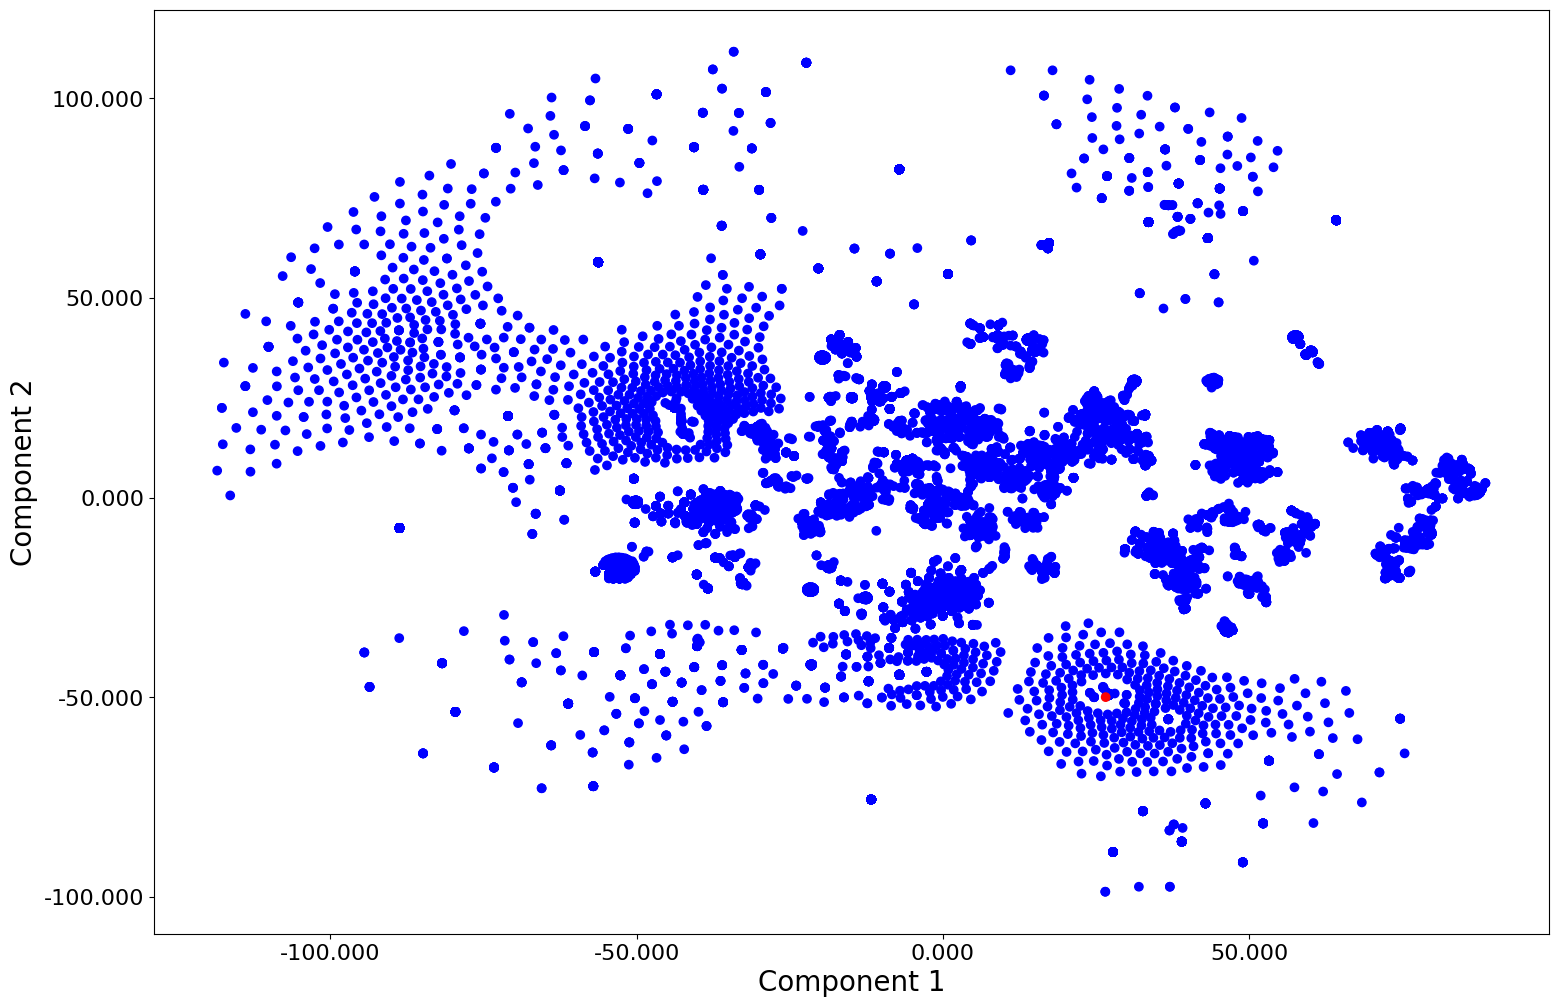

In [9]:
# now visualize the features
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# initialize the t-SNE
tsne = TSNE(n_components=2, perplexity=100)

# fit the t-SNE
X_embedded = tsne.fit_transform(dfFeatures)

# Create a color map based on the values in the first column
colors = ['blue' if val == 0.0 else 'red' for val in df['type']]

# plot the t-SNE
plt.figure(figsize=(18, 12))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Format the tick labels to 3 decimal places
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.3f}'))

plt.show()

## Fine tuning

In this part of the tutorial, we fine tune our model to predict declarations of functions. We use kNN classifier for that reason.

There are two steps that we need to do:
1) add another column to the dataframe df, where we add information about if a declaration is a function
2) we train and validate the kNN classifier for that task

In [31]:
# now add another column to df
# if the index contains "(" then the type is 2.

df.loc[df.index.str.contains("\("), 'type'] = 2

In [34]:
# now train kNN to predict the type of the line
from sklearn.neighbors import KNeighborsClassifier

# initialize the kNN
knn = KNeighborsClassifier(n_neighbors=3)

# fit the kNN
knn.fit(dfFeatures, df['type'])

# predict the type of the line
knn.predict(dfFeatures)

# now validate the predictions
from sklearn.metrics import accuracy_score

fAccuracy = accuracy_score(df["type"], knn.predict(dfFeatures))

print(f'Accuracy of the training set: {fAccuracy}')

# now predict the type of the line "int x = 12;"

# extract features for the line
oneLineFeatures = feature_extraction("int f(x);")[0][0]

# convert features to a dataframe
dfLine = pd.DataFrame([oneLineFeatures])

# predict the type of the line
iType = knn.predict(dfLine)

print(f'The type of the line is: {iType}')



Accuracy of the training set: 0.9979923343675853
The type of the line is: [2]


# Summary

In this tutorial, we've learned how to train a simple transformer network. We downloaded the network's architecture from the HuggingFace hub, then we used our set of declarations of C variables and functions to train it.

The result of this training is the network that can help us to write declarations of functions in C. 

If you want to dive deeper into this topic, please do the following exercises:
1. For the fill-mask pipeline, change the predicted string to int main(int argc, <mask> *argv); observe whether the network can predict it; reflecton on the result. 
2. Reduce the number of training epochs to 1, train the network and check the suggestions; do the same for 10 epochs, 20, etc. Observe and reflect upon the quality of the suggestions.
3. Go through the training set and add declarations that you are interested in, e.g., more variations of int main(....); train the network with 20-40 epochs and test your predictions. Observe how the suggestion changes if the network has a similar data in the training set and when it does not.
4. In many places I used the vocabulary size of 5000, please change that to 100, train the network and observe what happens. You can even go further and change this vocabulary size to 10 and do the same. 
5. When training the tokenizer, I used the parameter min_frequency=2, please change that to 10, then go through the entire process and see how that impacts results. Do the same for min_frequency=1. Whis parameter gives the best prediction?
6. Go through the code for visualization. Change the perplexity parameter of the t-SNE. Plot a few diagrams, reflect on how this parameter helps in understanding the data. 